In [1]:
import numpy as np
import torch

import os

from data.adapter import load_gwhd_df, GwhdToYoloAdapter

print("Checking environment variables...")
assert 'PROJ_PATH' in os.environ
assert 'YOLOV7_ROOT_DIR' in os.environ
assert 'DATASET_MD5' in os.environ
assert 'DATASET_ROOT_DIR' in os.environ
assert 'DATA_BUCKET' in os.environ
print("Environment variables exist.")

DATASET_ROOT_DIR = os.environ['DATASET_ROOT_DIR']

/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking environment variables...
Environment variables exist.


In [2]:
"""Load pandas frames describing datasets"""
train_df = load_gwhd_df(os.path.join(DATASET_ROOT_DIR, 'competition_train.csv'))
test_df = load_gwhd_df(os.path.join(DATASET_ROOT_DIR, 'competition_test.csv'))
val_df = load_gwhd_df(os.path.join(DATASET_ROOT_DIR, 'competition_val.csv'))
train_df

,image_name,BoxesString,domain,image_id,class_id,class_name,Box,xmin,ymin,xmax,ymax,has_annotation
0,0007634580386bd39d4d0d24df58893c3bb967e12d6fc0...,936 4 977 82;966 0 1023 114;665 9 795 79;877 0...,Arvalis_11,0,0.0,wheat_head,936 4 977 82,936.0,4.0,977.0,82.0,True
1,0007634580386bd39d4d0d24df58893c3bb967e12d6fc0...,936 4 977 82;966 0 1023 114;665 9 795 79;877 0...,Arvalis_11,0,0.0,wheat_head,966 0 1023 114,966.0,0.0,1023.0,114.0,True
2,0007634580386bd39d4d0d24df58893c3bb967e12d6fc0...,936 4 977 82;966 0 1023 114;665 9 795 79;877 0...,Arvalis_11,0,0.0,wheat_head,665 9 795 79,665.0,9.0,795.0,79.0,True
3,0007634580386bd39d4d0d24df58893c3bb967e12d6fc0...,936 4 977 82;966 0 1023 114;665 9 795 79;877 0...,Arvalis_11,0,0.0,wheat_head,877 0 958 20,877.0,0.0,958.0,20.0,True
4,0007634580386bd39d4d0d24df58893c3bb967e12d6fc0...,936 4 977 82;966 0 1023 114;665 9 795 79;877 0...,Arvalis_11,0,0.0,wheat_head,742 0 852 132,742.0,0.0,852.0,132.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
163625,fff24daa579e1e2752e320f7f8c6b654249a66d1f18cb2...,402 0 491 114;556 35 605 149;500 130 567 186;7...,Arvalis_8,3653,0.0,wheat_head,235 910 283 937,235.0,910.0,283.0,937.0,True
163626,fff24daa579e1e2752e320f7f8c6b654249a66d1f18cb2...,402 0 491 114;556 35 605 149;500 130 567 186;7...,Arvalis_8,3653,0.0,wheat_head,961 530 998 572,961.0,530.0,998.0,572.0,True
163627,fff24daa579e1e2752e320f7f8c6b654249a66d1f18cb2...,402 0 491 114;556 35 605 149;500 130 567 186;7...,Arvalis_8,3653,0.0,wheat_head,980 470 997 522,980.0,470.0,997.0,522.0,True
163628,fff24daa579e1e2752e320f7f8c6b654249a66d1f18cb2...,402 0 491 114;556 35 605 149;500 130 567 186;7...,Arvalis_8,3653,0.0,wheat_head,787 452 851 488,787.0,452.0,851.0,488.0,True


In [3]:
"""Instantiate adapters providing interface between df descriptors and yolov7 dataset"""
train_adapter = GwhdToYoloAdapter(os.path.join(DATASET_ROOT_DIR, 'images'), train_df, None)
test_adapter = GwhdToYoloAdapter(os.path.join(DATASET_ROOT_DIR, 'images'), test_df, None)
val_adapter = GwhdToYoloAdapter(os.path.join(DATASET_ROOT_DIR, 'images'), val_df, None)

INFO:pytorch_accelerated:Setting random seeds


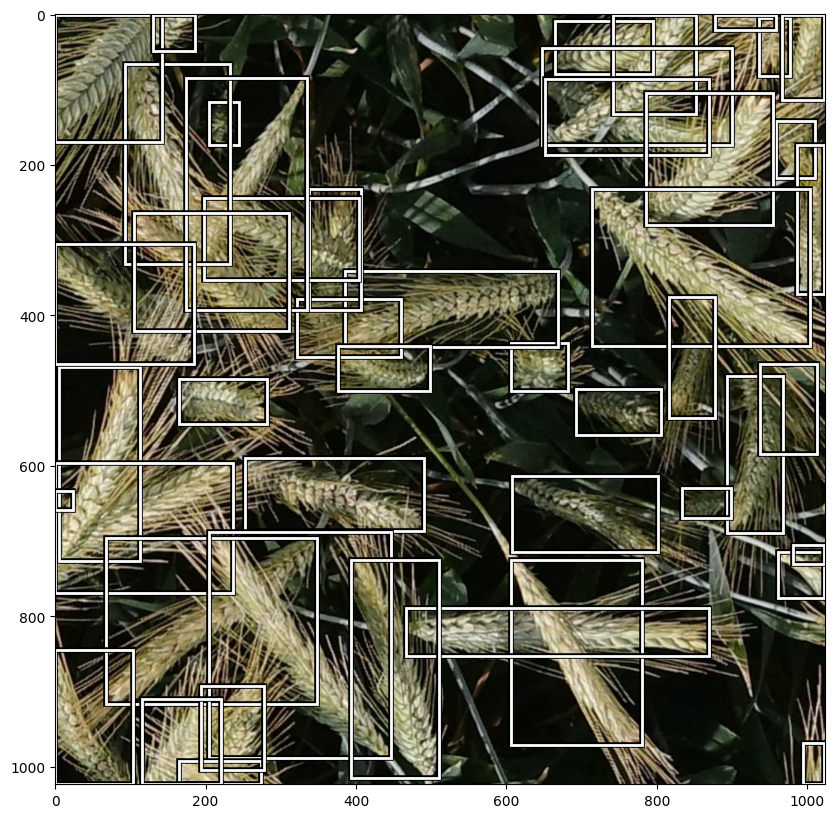

In [4]:
from yolov7.dataset import Yolov7Dataset
from yolov7.plotting import show_image

"""Instantiate yolov7 datasets"""
yolo_train_ds = Yolov7Dataset(train_adapter)
yolo_test_ds = Yolov7Dataset(test_adapter)
yolo_val_ds = Yolov7Dataset(val_adapter)

# Test if fetching image works properly
image_tensor, labels, image_id, image_size = yolo_train_ds[0]

# Denormalize boxes
boxes = labels[:, 2:]
boxes[:, [0, 2]] *= image_size[1]
boxes[:, [1, 3]] *= image_size[0]

show_image(image_tensor.permute(1, 2, 0), boxes.tolist(), None, 'cxcywh')

In [5]:
from yolov7 import create_yolov7_model
from yolov7.loss_factory import create_yolov7_loss

model = create_yolov7_model('yolov7-tiny', num_classes=1, pretrained=True)
loss_func = create_yolov7_loss(model, image_size=image_size[0])
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9, nesterov=True
)

Transferred 330/338 items from https://github.com/Chris-hughes10/Yolov7-training/releases/download/0.1.0/yolov7-tiny_state_dict.pt
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
Before init:  0.7
Image size:  tensor([1024, 1024])  original image size:  640
Multiplied by:  tensor([2.5600, 2.5600])  and  1.0
at init:  tensor([1.7920, 1.7920])


In [6]:
from functools import partial
from yolov7.trainer import Yolov7Trainer
from yolov7.trainer import filter_eval_predictions
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from pytorch_accelerated.callbacks import (
    EarlyStoppingCallback,
    SaveBestModelCallback,
    get_default_callbacks
)

# Create trainer and train
trainer = Yolov7Trainer(
    model=model,
    optimizer=optimizer,
    loss_func=loss_func,
    filter_eval_predictions_fn=partial(
        filter_eval_predictions, confidence_threshold=0.01, nms_threshold=0.3
    ),
    callbacks=[
        CalculateMeanAveragePrecisionCallback.create_from_targets_df(
            targets_df=val_df.query("has_annotation == True")[
                ["image_id", "xmin", "ymin", "xmax", "ymax", "class_id"]
            ],
            image_ids=set(val_df.image_id.unique()),
            iou_threshold=0.2,
        ),
        SaveBestModelCallback(watch_metric="map", greater_is_better=True),
        EarlyStoppingCallback(
            early_stopping_patience=3,
            watch_metric="map",
            greater_is_better=True,
            early_stopping_threshold=0.001,
        ),
        *get_default_callbacks(progress_bar=True),
    ],
)


In [7]:
from pytorch_accelerated.schedulers import CosineLrScheduler
from yolov7.dataset import yolov7_collate_fn

trainer.train(
        num_epochs=100,
        train_dataset=yolo_train_ds,
        eval_dataset=yolo_val_ds,
        per_device_batch_size=1,
        create_scheduler_fn=CosineLrScheduler.create_scheduler_fn(
            num_warmup_epochs=5,
            num_cooldown_epochs=5,
            k_decay=2,
        ),
        collate_fn=yolov7_collate_fn,
)


Starting training run

Starting epoch 1


  0%|          | 0/3654 [00:00<?, ?it/s]

loss box:  tensor([1.2021], device='cuda:0', grad_fn=<AddBackward0>)
loss ob:  tensor([3.6993], device='cuda:0', grad_fn=<AddBackward0>)
weight:  tensor([1.7920, 1.7920])
loss cls:  tensor([0.], device='cuda:0')


RuntimeError: output with shape [1] doesn't match the broadcast shape [2]

In [ ]:
model.eval()

with torch.no_grad():
    outputs = model(image_tensor[None])
    preds = model.postprocess(outputs, conf_thres=0.5, multiple_labels_per_box=False)

In [ ]:
preds[0].shape #xyxy coordinates, confidence score, class id

torch.Size([23106, 6])

In [ ]:
filtered_preds = filter_eval_predictions(preds, confidence_threshold=0.5)
filtered_preds[0].shape

torch.Size([22380, 6])